# Задание №3, часть А

## Загрузка данных

In [140]:
# ! curl http://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data > ./data/ionosphere.data

## Подготовка данных

In [141]:
from random import random
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pandas
import numpy

numpy.random.seed(110)

In [142]:
# Загружаем данные
data = pandas.read_csv('./data/ionosphere.data', header=None) # Load data
data.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [143]:
# Делим на обучающую и тестовую выборки
train, test = train_test_split(data, test_size=0.3)

X_train = train[range(0, 34)]
y_train = train[34]
y_train.name = "class"

X_test = test[range(0, 34)]
y_test = test[34]
y_train.name = "class"

In [144]:
# Масштабируем и понижаем размерность
from typing import NamedTuple
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.preprocessing import RobustScaler

class ScaledData(NamedTuple):
    umap: object
    tsne: object

X = data[range(0, 34)]
y = data[34]

scaler = RobustScaler() # Выбран так как в предыдущей работе показал наилучшую эффективность.
umap_reducer = UMAP()
tsne_reducer = TSNE(init='random', learning_rate='auto')

scaler.fit(X)
X_train = ScaledData(
    umap=pandas.DataFrame(umap_reducer.fit_transform(scaler.transform(X_train)), columns=['p1', 'p2']),
    tsne=pandas.DataFrame(tsne_reducer.fit_transform(scaler.transform(X_train)), columns=['p1', 'p2'])
)

X_test = ScaledData(
    umap=pandas.DataFrame(umap_reducer.fit_transform(scaler.transform(X_test)), columns=['p1', 'p2']),
    tsne=pandas.DataFrame(tsne_reducer.fit_transform(scaler.transform(X_test)), columns=['p1', 'p2'])
)

X_train.umap

,p1,p2
0,9.041247,5.224333
1,4.262116,6.182809
2,9.086637,6.767396
3,9.393382,9.806565
4,4.532207,5.508913
...,...,...
240,8.763042,9.491966
241,9.842462,7.765315
242,8.056917,5.199013
243,4.273627,5.936635


## Построение модели
Строится модель простого классификатора, для того чтобы оценить потом профит от подбора гиперпараметров

In [145]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def scores(y_true, y_pred):
    return { 
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, labels=['g', 'b'], pos_label='g'),
        "f1": f1_score(y_true, y_pred, labels=['g', 'b'], pos_label='g'),
        "recall": recall_score(y_true, y_pred, labels=['g', 'b'], pos_label='g'),
    }

classifier = SVC(kernel="linear")
model = classifier.fit(X_train.umap, y_train)

y_predicted = classifier.predict(X_test.umap)
print(scores(y_test, y_predicted))

{'accuracy': 0.5094339622641509, 'precision': 0.9285714285714286, 'f1': 0.5, 'recall': 0.34210526315789475}


## Подбор гиперпараметров

In [146]:
from sklearn.model_selection import GridSearchCV

class Result(NamedTuple):
    y_predicted: object
    classifier: object

parameters = { "kernel": ["linear", "rbf", "poly", "sigmoid"],
               "C": list(map(lambda x: x/10, range(1, 11, 1))) }

scaled_sets = [
    ("UMAP", X_train.umap, X_test.umap), 
    ('T-SNE', X_train.tsne, X_test.tsne)]

results = {}

for label, X_train_, X_test_ in scaled_sets:
    classifier = GridSearchCV(SVC(), param_grid=parameters)

    model = classifier.fit(X_train_.values, y_train.values)

    classifier = model.best_estimator_
    y_predicted = classifier.predict(X_test_.values)
    results[label] = Result(y_predicted, classifier)
    print(label, model.best_params_)
    print(label, scores(y_test, y_predicted))

UMAP {'C': 0.2, 'kernel': 'rbf'}
UMAP {'accuracy': 0.7169811320754716, 'precision': 0.9791666666666666, 'f1': 0.7580645161290323, 'recall': 0.618421052631579}
T-SNE {'C': 1.0, 'kernel': 'rbf'}
T-SNE {'accuracy': 0.37735849056603776, 'precision': 0.7777777777777778, 'f1': 0.2978723404255319, 'recall': 0.18421052631578946}


## Визуализация

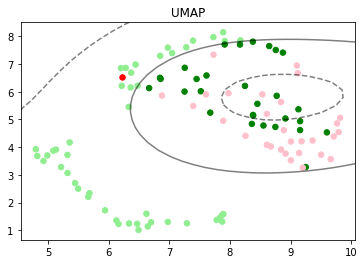

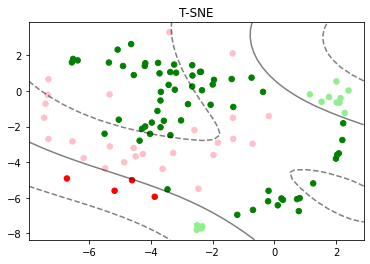

In [147]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_SVM(X, y_act, y_pred, clf, text):
    Y = pandas.concat([pandas.Series(y_act, name="class"), pandas.Series(y_pred, name="pred", index=y_act.index)], axis=1)
    color_map = {"gg": "lightgreen", "bb": "pink", "gb": "green", "bg": "red"}
    colors = Y.apply(lambda x: x['class'] + x['pred'], axis=1).map(color_map)
    
    plt.scatter(X["p1"], X["p2"], c=colors, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = numpy.linspace(xlim[0], xlim[1], 30)
    yy = numpy.linspace(ylim[0], ylim[1], 30)
    YY, XX = numpy.meshgrid(yy, xx)
    xy = numpy.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    ax.contour(XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"])
    plt.title(text)
    plt.show()

for label, X_train_, X_test_ in scaled_sets:
    plot_SVM(X_test_, y_test, results[label].y_predicted, results[label].classifier, label)